## Import Statement

In [143]:
from pyspark.sql import SQLContext
from handyspark import *
from pyspark.sql import functions as sf
from matplotlib import pyplot as plt
from pyspark.sql.functions import col, avg
import pandas as pd
from pyspark.sql.window import Window

In [144]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)
LOGGER.error("pyspark script logger initialized")

In [145]:
base_path = "/home/darkmatter/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)
household_info = sqlcontext.read.csv(base_path+"informations_households.csv",header=True,inferSchema=True)
household_mini = sc.parallelize(household_info.take(15)).toDF()
# household_mini = household_info

In [146]:
household_mini.show()

+---------+--------+-------+-------------+-------+
|    LCLid|stdorToU|  Acorn|Acorn_grouped|   file|
+---------+--------+-------+-------------+-------+
|MAC005492|     ToU| ACORN-|       ACORN-|block_0|
|MAC001074|     ToU| ACORN-|       ACORN-|block_0|
|MAC000002|     Std|ACORN-A|     Affluent|block_0|
|MAC003613|     Std|ACORN-A|     Affluent|block_0|
|MAC003597|     Std|ACORN-A|     Affluent|block_0|
|MAC003579|     Std|ACORN-A|     Affluent|block_0|
|MAC003566|     Std|ACORN-A|     Affluent|block_0|
|MAC003557|     Std|ACORN-A|     Affluent|block_0|
|MAC003553|     Std|ACORN-A|     Affluent|block_0|
|MAC003482|     Std|ACORN-A|     Affluent|block_0|
|MAC003463|     Std|ACORN-A|     Affluent|block_0|
|MAC003449|     Std|ACORN-A|     Affluent|block_0|
|MAC003428|     Std|ACORN-A|     Affluent|block_0|
|MAC003423|     Std|ACORN-A|     Affluent|block_0|
|MAC003422|     Std|ACORN-A|     Affluent|block_0|
+---------+--------+-------+-------------+-------+



In [147]:
column_list = []
for i in range(48):
    column_list.append("hh_"+str(i))
column_list
new_column_list = []
for i in range(1,49):
    if i<20:
        new_column_list.append("0"+str(i*0.5))
    else:
        new_column_list.append(str(i*0.5))

In [157]:
flag = 0
avg_house_data = []
df_file = household_mini.select("file").distinct()
# exprs = {x: "avg" for x in new_column_list}
exprs1 = [avg(x) for x in column_list[0:40]]
exprs2 = [avg(x) for x in column_list[40:48]]        #due to the fact large number of column giving error so divide
for row in df_file.rdd.collect():
    file = row.file
    print(file)
    file_path = base_path + "hhblock_dataset/"+ file+".csv"
    half_hourly_consumption_data = sqlcontext.read.csv(file_path,header=True,inferSchema=True)
    half_hourly_consumption_data.dropna(how='any')
    half_hourly_consumption_data2 = half_hourly_consumption_data.groupBy('LCLid').agg(*exprs2)
    half_hourly_consumption_data = half_hourly_consumption_data.groupBy('LCLid').agg(*exprs1)
    half_hourly_consumption_data = half_hourly_consumption_data.join(half_hourly_consumption_data2,["LCLid"])
    half_hourly_consumption_data.dropna(how='any')
    half_hourly_consumption_data.printSchema()
    if flag == 0:
        avg_house_data = sqlcontext.createDataFrame([],half_hourly_consumption_data.schema)
        flag = 1
    avg_house_data = avg_house_data.union(half_hourly_consumption_data)

block_0
root
 |-- LCLid: string (nullable = true)
 |-- avg(hh_0): double (nullable = true)
 |-- avg(hh_1): double (nullable = true)
 |-- avg(hh_2): double (nullable = true)
 |-- avg(hh_3): double (nullable = true)
 |-- avg(hh_4): double (nullable = true)
 |-- avg(hh_5): double (nullable = true)
 |-- avg(hh_6): double (nullable = true)
 |-- avg(hh_7): double (nullable = true)
 |-- avg(hh_8): double (nullable = true)
 |-- avg(hh_9): double (nullable = true)
 |-- avg(hh_10): double (nullable = true)
 |-- avg(hh_11): double (nullable = true)
 |-- avg(hh_12): double (nullable = true)
 |-- avg(hh_13): double (nullable = true)
 |-- avg(hh_14): double (nullable = true)
 |-- avg(hh_15): double (nullable = true)
 |-- avg(hh_16): double (nullable = true)
 |-- avg(hh_17): double (nullable = true)
 |-- avg(hh_18): double (nullable = true)
 |-- avg(hh_19): double (nullable = true)
 |-- avg(hh_20): double (nullable = true)
 |-- avg(hh_21): double (nullable = true)
 |-- avg(hh_22): double (nullable = 

In [158]:
half_hourly_consumption_data.show()

+---------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|    LCLid|          avg(hh_

In [142]:
flag = 0
avg_house_data = []
block_read = set([])
for row in household_mini.rdd.collect():
    house_id = row.LCLid
    file = row.file
    print(house_id,file)
    file_path = base_path + "hhblock_dataset/"+ file+".csv"
    if file not in block_read:
#         print("hi")
        block_read.add(file)
        half_hourly_consumption_data = sqlContext.read.csv(file_path,header=True,inferSchema=True)
        half_hourly_consumption_data.dropna(how='any')
        for c,n in zip(column_list,new_column_list):
            half_hourly_consumption_data=half_hourly_consumption_data.withColumnRenamed(c,n)
    indiv_house_data = half_hourly_consumption_data.where(col("LCLid") == house_id)
    indiv_house_data = indiv_house_data.toHandy()
    if indiv_house_data.rdd.isEmpty():
        print("Missing Id = {} in file = {}".format(house_id,file))
        continue
    indiv_house_data = sqlcontext.createDataFrame(indiv_house_data.stratify(['LCLid']).cols[new_column_list].mean().reset_index())
#     indiv_house_data.printSchema()
    if flag == 0:
        avg_house_data = sqlcontext.createDataFrame([],indiv_house_data.schema)
        flag = 1
    avg_house_data = avg_house_data.union(indiv_house_data)

MAC005492 block_0


KeyboardInterrupt: 

In [159]:
for c,n in zip(avg_house_data.columns[1:],new_column_list):
    avg_house_data=avg_house_data.withColumnRenamed(c,n)
avg_house_data.show()

+---------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|    LCLid|               00

In [160]:
avg_house_data = avg_house_data.toPandas().set_index("LCLid")

In [162]:
# pd.options.display.max_columns = None
avg_house_data.head(15)

,00.5,01.0,01.5,02.0,02.5,03.0,03.5,04.0,04.5,05.0,...,19.5,20.0,20.5,21.0,21.5,22.0,22.5,23.0,23.5,24.0
LCLid,,,,,,,,,,,,,,,,,,,,,
MAC003668,0.568259,0.349559,0.299375,0.287401,0.280257,0.268375,0.271603,0.269102,0.264774,0.268034,...,1.669683,1.618649,1.602337,1.610733,1.562375,1.517876,1.402477,1.225683,1.009651,0.706832
MAC003252,0.179918,0.159682,0.142561,0.129201,0.123376,0.112485,0.107809,0.108986,0.106324,0.102786,...,0.500097,0.456021,0.428996,0.391881,0.379382,0.342082,0.332353,0.297585,0.254524,0.215283
MAC005492,0.157703,0.143552,0.131069,0.115051,0.108279,0.101929,0.099665,0.101306,0.100933,0.102789,...,0.234934,0.227636,0.223246,0.224909,0.213734,0.212876,0.197464,0.191812,0.179831,0.172800
MAC003775,0.507067,0.412067,0.334516,0.301156,0.322469,0.374855,0.439270,0.523467,0.604000,0.611629,...,0.890232,0.841333,0.852978,0.744270,0.684949,0.668009,0.659473,0.657650,0.657000,0.590158
MAC003400,0.191321,0.150178,0.117618,0.102184,0.090959,0.087450,0.085241,0.083971,0.090640,0.088331,...,0.368409,0.402726,0.408583,0.435932,0.477984,0.513519,0.498311,0.461485,0.383301,0.265268
MAC003613,0.365728,0.339974,0.315864,0.305158,0.333670,0.323124,0.313188,0.319174,0.328498,0.384596,...,0.828098,0.887242,0.873870,0.799502,0.716618,0.613994,0.528666,0.490796,0.470064,0.411502
MAC003718,0.232266,0.194806,0.132006,0.114645,0.109524,0.107457,0.107440,0.104906,0.101343,0.103150,...,0.302252,0.301366,0.295773,0.290737,0.276440,0.287906,0.306532,0.400931,0.359637,0.376391
MAC003597,0.359120,0.353834,0.353806,0.351419,0.350026,0.348343,0.348559,0.345086,0.347559,0.342158,...,1.067289,1.059920,1.055387,1.026475,1.063144,0.917820,0.779567,0.667006,0.468529,0.375952
MAC003463,0.145347,0.126958,0.120421,0.116039,0.116939,0.117299,0.116945,0.117177,0.117354,0.119775,...,0.596457,0.539109,0.492756,0.457807,0.466424,0.415132,0.327466,0.289939,0.223090,0.180331


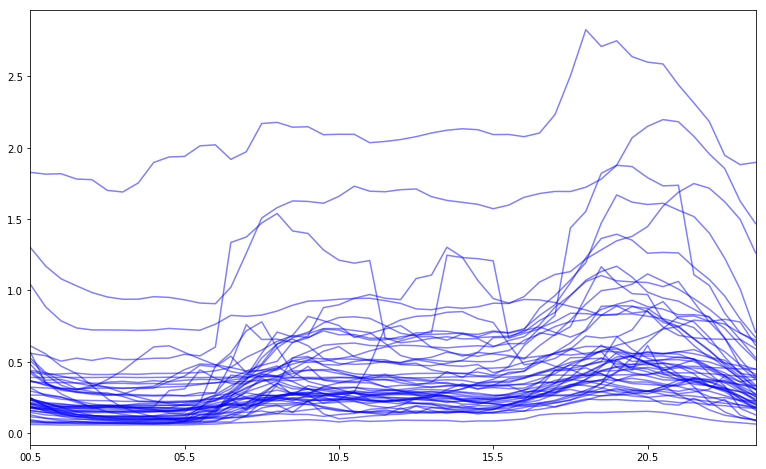

In [163]:
avg_house_data.T.plot(figsize=(13,8), legend=False, color='blue',alpha=0.5)

In [22]:
avg_house_data.to_csv(base_path+"avg.csv")